# SI Spreading on Similarity Network

Measure node influence by spreading speed in weighted similarity network.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Load Network

In [2]:
# Load and build network
interactions = pd.read_csv('../data/raw/small_matrix.csv')

user_video_matrix = interactions.pivot_table(
    index='user_id',
    columns='video_id',
    values='watch_ratio',
    fill_value=0
)

similarity_matrix = cosine_similarity(user_video_matrix.values)
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=user_video_matrix.index,
    columns=user_video_matrix.index
)

G = nx.Graph()
users = user_video_matrix.index.tolist()
G.add_nodes_from(users)

for i, user_i in enumerate(users):
    for j, user_j in enumerate(users[i+1:], start=i+1):
        sim = similarity_df.loc[user_i, user_j]
        G.add_edge(user_i, user_j, weight=sim)

print(f"Network: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")
print(f"Mean similarity: {np.mean([d['weight'] for u, v, d in G.edges(data=True)]):.3f}")

Network: 1,411 nodes, 994,755 edges
Mean similarity: 0.571


## 2. SI Model

Transmission probability = β × edge weight (similarity)

In [3]:
def run_si(G, seed, beta, max_steps=50):
    """Run SI simulation, return infected counts over time."""
    infected = {seed}
    counts = [1]
    
    for t in range(max_steps):
        new_infected = set()
        for node in infected:
            for neighbor in G.neighbors(node):
                if neighbor not in infected:
                    if np.random.random() < beta * G[node][neighbor]['weight']:
                        new_infected.add(neighbor)
        
        if not new_infected:
            break
        infected.update(new_infected)
        counts.append(len(infected))
    
    return counts


def measure_influence(G, seed, beta, num_runs=30):
    """Measure spreading speed metrics for a seed node."""
    threshold_50 = G.number_of_nodes() * 0.5
    threshold_90 = G.number_of_nodes() * 0.9
    
    times_to_50 = []
    times_to_90 = []
    size_at_t10 = []
    final_sizes = []
    
    for _ in range(num_runs):
        counts = run_si(G, seed, beta)
        
        # Time to 50%
        t50 = next((t for t, c in enumerate(counts) if c >= threshold_50), len(counts))
        times_to_50.append(t50)
        
        # Time to 90%
        t90 = next((t for t, c in enumerate(counts) if c >= threshold_90), len(counts))
        times_to_90.append(t90)
        
        # Size at t=10
        size_at_t10.append(counts[10] if len(counts) > 10 else counts[-1])
        
        # Final size
        final_sizes.append(counts[-1])
    
    return {
        'time_to_50': np.mean(times_to_50),
        'time_to_90': np.mean(times_to_90),
        'size_at_t10': np.mean(size_at_t10),
        'final_size': np.mean(final_sizes),
        'std_time_50': np.std(times_to_50),
    }

## 3. Test Seeds

In [4]:
# Compute strength
strength = dict(G.degree(weight='weight'))
pagerank = nx.pagerank(G, weight='weight')

# Select test seeds
top_strength = sorted(strength.items(), key=lambda x: x[1], reverse=True)
bottom_strength = sorted(strength.items(), key=lambda x: x[1])

test_seeds = {
    'High Strength': top_strength[0][0],
    'Low Strength': bottom_strength[0][0],
    'Medium Strength': top_strength[len(top_strength)//2][0],
    'Random': np.random.choice(users),
}

print("Test seeds:")
for label, node in test_seeds.items():
    print(f"  {label:15s}: User {node:5d} (strength={strength[node]:.1f})")

Test seeds:
  High Strength  : User  1626 (strength=1061.8)
  Low Strength   : User   839 (strength=120.8)
  Medium Strength: User  2687 (strength=868.6)
  Random         : User   865 (strength=804.1)


## 4. Run Test Simulations

In [5]:
BETA = 0.3
NUM_RUNS = 50

print(f"Running SI simulations (β={BETA}, {NUM_RUNS} runs per seed)...\n")

test_results = {}
for label, seed in test_seeds.items():
    metrics = measure_influence(G, seed, BETA, NUM_RUNS)
    test_results[label] = metrics
    print(f"{label:15s}: t50={metrics['time_to_50']:5.1f}, t90={metrics['time_to_90']:5.1f}, size@t10={metrics['size_at_t10']:6.1f}")

print("\nObservation: Does high strength → faster spreading?")

Running SI simulations (β=0.3, 50 runs per seed)...

High Strength  : t50=  2.0, t90=  2.0, size@t10=1411.0
Low Strength   : t50=  2.0, t90=  2.0, size@t10=1411.0
Medium Strength: t50=  2.0, t90=  2.0, size@t10=1411.0
Random         : t50=  2.0, t90=  2.0, size@t10=1411.0

Observation: Does high strength → faster spreading?


## 5. Visualize Spreading Curves

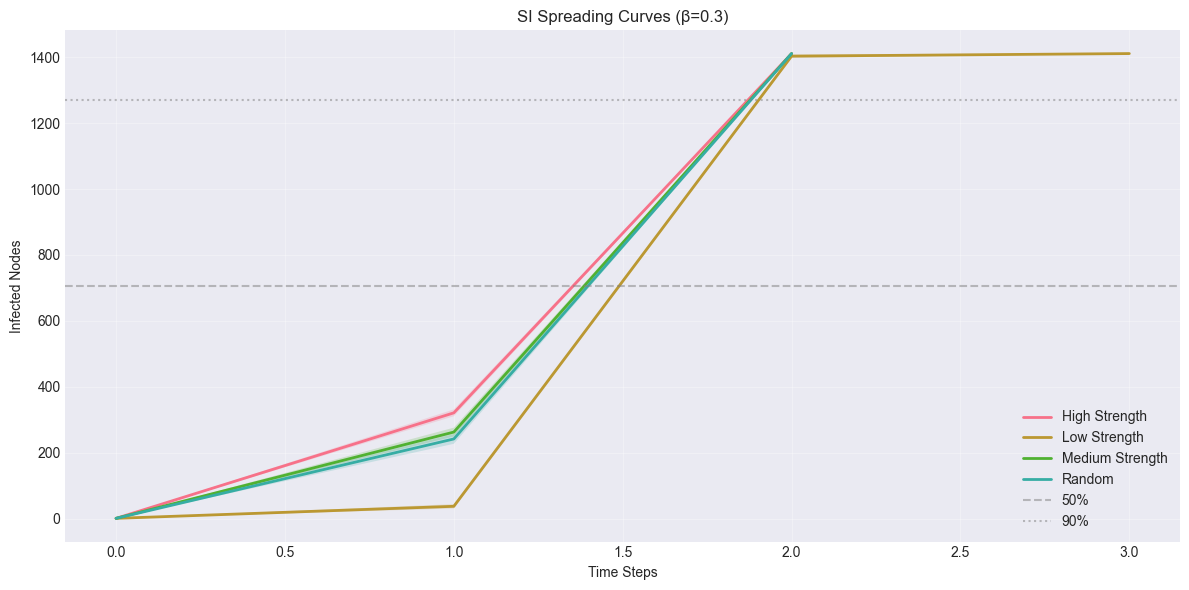

In [6]:
# Run multiple simulations for visualization
plt.figure(figsize=(12, 6))

for label, seed in test_seeds.items():
    curves = [run_si(G, seed, BETA) for _ in range(30)]
    
    # Pad and average
    max_len = max(len(c) for c in curves)
    padded = [c + [c[-1]] * (max_len - len(c)) for c in curves]
    mean_curve = np.mean(padded, axis=0)
    std_curve = np.std(padded, axis=0)
    
    times = np.arange(len(mean_curve))
    plt.plot(times, mean_curve, linewidth=2, label=label)
    plt.fill_between(times, mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)

plt.axhline(G.number_of_nodes() * 0.5, color='gray', linestyle='--', alpha=0.5, label='50%')
plt.axhline(G.number_of_nodes() * 0.9, color='gray', linestyle=':', alpha=0.5, label='90%')
plt.xlabel('Time Steps')
plt.ylabel('Infected Nodes')
plt.title(f'SI Spreading Curves (β={BETA})')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Measure All Nodes

In [ ]:
NUM_RUNS_PER_NODE = 20

print(f"Measuring influence for all {len(users)} nodes...")
print(f"β={BETA}, {NUM_RUNS_PER_NODE} runs per node (5-10 min)\n")

influence = {}
for node in tqdm(users):
    metrics = measure_influence(G, node, BETA, NUM_RUNS_PER_NODE)
    influence[node] = {
        **metrics,
        'strength': strength[node],
        'pagerank': pagerank[node],
    }

# Convert to DataFrame
df = pd.DataFrame.from_dict(influence, orient='index')
df.index.name = 'user_id'
df = df.sort_values('time_to_50')

print("\nTop 10 fastest spreaders (lowest time to 50%):")
print(df.head(10)[['time_to_50', 'time_to_90', 'strength', 'pagerank']].to_string())

print("\nBottom 10 slowest spreaders:")
print(df.tail(10)[['time_to_50', 'time_to_90', 'strength', 'pagerank']].to_string())

Measuring influence for all 1411 nodes...
β=0.3, 20 runs per node (5-10 min)



 12%|█▏        | 166/1411 [35:25<3:57:57, 11.47s/it]

## 7. Correlation Analysis

In [ ]:
# Correlations (note: faster spreading = lower time, so negative correlation expected)
corr_strength_t50 = df['time_to_50'].corr(df['strength'])
corr_pagerank_t50 = df['time_to_50'].corr(df['pagerank'])
corr_strength_size = df['size_at_t10'].corr(df['strength'])

print("Correlation with spreading speed:")
print("="*60)
print(f"Time to 50% vs Strength:  {corr_strength_t50:7.4f} (negative = faster)")
print(f"Time to 50% vs PageRank:  {corr_pagerank_t50:7.4f}")
print(f"Size@t10 vs Strength:     {corr_strength_size:7.4f} (positive = larger)")
print()
print("Interpretation:")
if corr_strength_t50 < -0.7:
    print("  ✓ Strength STRONGLY predicts fast spreading")
elif corr_strength_t50 < -0.3:
    print("  → Strength moderately predicts fast spreading")
else:
    print("  ✗ Strength weakly predicts spreading speed")

In [ ]:
# Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(df['strength'], df['time_to_50'], alpha=0.5, s=30)
axes[0].set_xlabel('Strength')
axes[0].set_ylabel('Time to 50% Infection')
axes[0].set_title(f'Spreading Speed vs Strength (r={corr_strength_t50:.3f})')
axes[0].grid(alpha=0.3)

axes[1].scatter(df['strength'], df['size_at_t10'], alpha=0.5, s=30)
axes[1].set_xlabel('Strength')
axes[1].set_ylabel('Outbreak Size at t=10')
axes[1].set_title(f'Early Outbreak vs Strength (r={corr_strength_size:.3f})')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Save Results

In [ ]:
import os
os.makedirs('../results', exist_ok=True)

# Save influence rankings
df.to_csv('../results/similarity_network_influence.csv')
print("Saved: results/similarity_network_influence.csv")

# Save summary
summary = pd.DataFrame([{
    'network_type': 'similarity_weighted',
    'num_nodes': G.number_of_nodes(),
    'density': nx.density(G),
    'beta': BETA,
    'metric': 'time_to_50',
    'corr_strength': corr_strength_t50,
    'corr_pagerank': corr_pagerank_t50,
    'fastest_node': df.index[0],
    'slowest_node': df.index[-1],
}])
summary.to_csv('../results/similarity_network_summary.csv', index=False)
print("Saved: results/similarity_network_summary.csv")

print("\nReady for Wednesday comparison!")